# Pytorch beginner course: XOR problem using MLP

## Summary

- [XOR problem: introduction](#xor-problem-introduction)
- [Multilayer Percpetro (MLP): main theory](#multilayer-perceptron-mlp-main-theory)
- [Implementation](#implementation)
  - [Boundary decision plot function](#boundary-decision-plot-function)
  - [MLP implementation using pytorch](#mlp-implementation-using-pytorch)

## XOR problem: introduction

In this work we try to explain how we can solve the problem of XOR port with neural networks, `1969` Minsky and Papert showed that the **single layer percpetron** does not solve this problem because a percpetron sets the weight only with the linear separation surface, but in the XOR case this solution is not appropriate because the two inputs of the XOR are not linear.

The solution to this problem is the MLP (Multilayer Percpetron), because in MLP case we can divide fine the boundary decision areas of our XOR gates.

![XOR truth table](./images/XOR_truth_table.svg)

*XOR gate truth table*

## Multilayer Perceptron (MLP): main theory

MLP networks are fully-connected feed-forward networks, with the term feed-forward means the property of the network to flow information "forward" within the network, In essence, the information found in a neuron in layer `i` can only be drawn to layer `i+1`.

The MLP networks ensure the **best approximation property**, the best approximation property tells us that a MLP with only one dense hidden layer composed of an adequate number of neurons produces a set of functions that can approximate any continuous function in $\mathbb{R}^{n}$ with a very small arbitrary error.

![MLP Architecture](./images/MLP.png)

## Implementation

Now we can see the code that implements the MLP to solve the XOR problem, our code explaination is divided in two different block:

1. Plot of the boundary decision
2. Main code that create a model in `pytorch` for the XOR problem

### Boundary decision plot function

This function is used to plot the boundary decision of our model.

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function which plot the boundary precision of our model
def plot_decision_boundary(X, y, model):
    # Set limits of the plot
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Prepare data and labels as meshgrid
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )

    # Convert numpy array to tensor, useful to predict result of trained model
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.from_numpy(grid).float()


    with torch.no_grad():
        Z = model(grid_tensor)
        Z = Z.numpy()  # from tensor to numpy
        Z = (Z >= 0.5).astype(int)  # binary classification threshold
    Z = Z.reshape(xx.shape)

    # Print boundary decision
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    # Print all points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
    plt.xlabel('A')
    plt.ylabel('B')
    plt.title('Decision Boundary')
    plt.show()

### MLP implementation using pytorch

The first step involve to the instantiation of the dataset, in this case our dataset is very small, thus avoid to use accelerator (CUDA), because our few data lead to memory bound bottleneck (too overhead to move data from CPU to DEVICE)

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

# Dataset
X = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])

# Labels
y = torch.tensor([[0.0],
                  [1.0],
                  [1.0],
                  [0.0]])

Now we can implement our simple MLP model extending the base class `nn.Module`.

Two hidden layers are enough to solve XOR problem, moreover is suggested to use hyperbolic tangent as activation function in order to reach the non linearity in a efficient way, if you try to use sigmoid you need more epochs to get a well generalized model.

In [84]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 2) # Hidden Layer 1: (2) Input from Input layer -> (2) Output to Hidden Layer 2
        self.fc2 = nn.Linear(2, 1) # Hidden Layer 2: (2) Input from Hidden layer 1 -> (1) Output to Output Layer

    # Move date ahead in the net
    def forward(self, x):
        # Apply hyperbolic tangent as activation function for each hidden layer 
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x
    

    # Train model
    def fit(self, X, y, loss_function, optimizer, epochs=100, loss_print_step=10):
        for epoch in range(epochs):
            optimizer.zero_grad()
            predictions = self(X)
            loss = loss_function(predictions, y)
            if epoch % loss_print_step == 0:
                print(f'Loss at Epoch {epoch}: {loss}')
            loss.backward()
            optimizer.step()
        # return predictions at the end of the train
        return predictions

Let's try it!

Loss at Epoch 0: 1.4708342552185059
Loss at Epoch 100: 0.23676913976669312
Loss at Epoch 200: 0.21734163165092468
Loss at Epoch 300: 0.1980605125427246
Loss at Epoch 400: 0.18576982617378235
Loss at Epoch 500: 0.17689892649650574
Loss at Epoch 600: 0.16770698130130768
Loss at Epoch 700: 0.1513655185699463
Loss at Epoch 800: 0.10979226231575012
Loss at Epoch 900: 0.04931943118572235
Loss at Epoch 1000: 0.018971271812915802
Loss at Epoch 1100: 0.009059164673089981
Loss at Epoch 1200: 0.005332242697477341
Loss at Epoch 1300: 0.0035949284210801125
Loss at Epoch 1400: 0.002642972394824028
Loss at Epoch 1500: 0.0020589856430888176
Loss at Epoch 1600: 0.0016707475297152996
Loss at Epoch 1700: 0.0013969155261293054
Loss at Epoch 1800: 0.0011948860483244061
Loss at Epoch 1900: 0.0010404984932392836

Model's predictions:
tensor([[0.0030],
        [0.9573],
        [0.9573],
        [0.0054]])

Prediction on tensor([[0., 1.]]) : 1


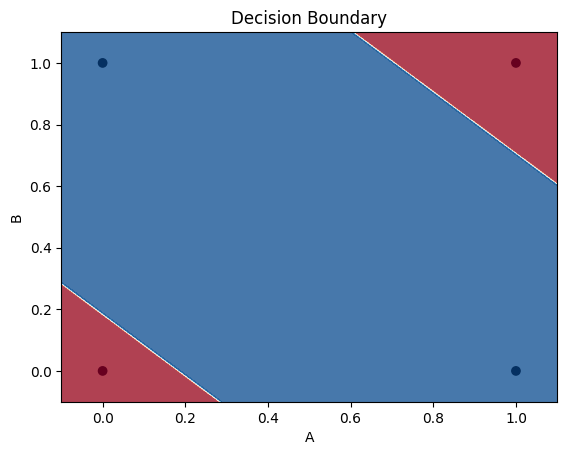

In [100]:
# model instatiation
model = MLP()

# Used optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train model
predictions = model.fit(X=X, y=y, epochs=2000, loss_print_step=100, loss_function=nn.MSELoss(), optimizer=optimizer)

# Outputs
print("\nModel's predictions:")
print(predictions.detach())

# Evalutation mode (disabled dropout and others properties which limit the net)
model.eval()

# Test model on a specific input
new_input = torch.tensor([[0.0,1.0]])
output = model(new_input)
prediction = (output >= 0.5).float()
print(f"\nPrediction on {new_input} : {int(prediction.item())}")

# Decision boundary
plot_decision_boundary(np.array(X), np.array(y), model)